In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [2]:
from branchynet.net import BranchyNet
from branchynet.links import *
import chainer.functions as F
import chainer.links as L
from branchynet import utils, visualize
from chainer import cuda

Define Network

In [3]:
from networks import lenet_mnist

branchyNet = lenet_mnist.get_network()
if cuda.available:
    branchyNet.to_gpu()
branchyNet.training()

Import Data

In [4]:
from datasets import mnist
training_size=500
x_train, y_train, x_test, y_test = mnist.get_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train, y_train, x_test, y_test = x_train[:training_size*6], y_train[:training_size*6], x_test[:training_size], y_test[:training_size]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


#x_test = x_train + x_test
#y_test = y_train + y_test
#training size = 6000, each epoch we need to 12 seconds.
#this app need 28 cores and at least 3GB memory for UTSA server when training size is 6000.x_test

/home/peng/cooperating/venv/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/peng/cooperating/venv/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))
((3000, 1, 28, 28), (3000,), (500, 1, 28, 28), (500,))


Settings

In [5]:
TRAIN_BATCHSIZE = 512
TEST_BATCHSIZE = 1
TRAIN_NUM_EPOCHS = 5

Train Main Network

In [ ]:
main_loss, main_acc, main_time = utils.train(branchyNet, x_train, y_train, main=True, batchsize=TRAIN_BATCHSIZE,
                                             num_epoch=TRAIN_NUM_EPOCHS)

1620860212.39
1620860218.23
1620860223.94
1620860229.79


Train BranchyNet

In [ ]:
#TRAIN_NUM_EPOCHS = 100
branch_loss, branch_acc, branch_time = utils.train(branchyNet, x_train, y_train, batchsize=TRAIN_BATCHSIZE,
                                                   num_epoch=TRAIN_NUM_EPOCHS)

#set network to inference mode
branchyNet.testing()

Visualizing Network Training

In [ ]:
visualize.plot_layers(main_loss, xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(main_acc, xlabel='Epochs', ylabel='Training Accuracy')

In [ ]:
visualize.plot_layers(zip(*branch_loss), xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(zip(*branch_acc), xlabel='Epochs', ylabel='Training Accuracy')

Run test suite and visualize

In [ ]:
#set network to inference mode
branchyNet.testing()
branchyNet.verbose = False
if cuda.available:
    branchyNet.to_gpu()
g_baseacc, g_basediff, _, _ = utils.test(branchyNet, x_test, y_test, main=True, batchsize=TEST_BATCHSIZE)
g_basediff = (g_basediff / float(len(y_test))) * 1000.

#branchyNet.to_cpu()
c_baseacc, c_basediff, _, _ = utils.test(branchyNet, x_test, y_test, main=True, batchsize=TEST_BATCHSIZE)
c_basediff = (c_basediff / float(len(y_test))) * 1000.

In [ ]:
# Specify thresholds
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1., 2., 3., 5., 10.]
# the best thresholds from brandynet.
thresholds = [0.025]

In [ ]:
#GPU
if cuda.available:
    branchyNet.to_gpu()
g_ts, g_accs, g_diffs, g_exits = utils.screen_branchy(branchyNet, x_test, y_test, thresholds,
                                                    batchsize=TEST_BATCHSIZE, verbose=True)

#convert to ms
g_diffs *= 1000.


In [ ]:
import matplotlib as plt
import numpy as np

print(g_accs)
print(g_diffs)
print(g_ts)
print(g_exits)
print(g_baseacc)
print(g_basediff)

tmp = np.array(g_accs)
#print(plt.rcParams.keys())

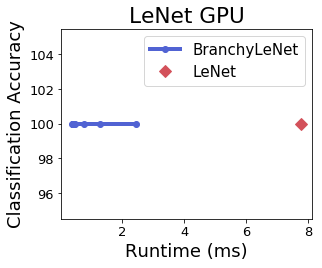

In [19]:
visualize.plot_line_tradeoff(g_accs, g_diffs, g_ts, g_exits, g_baseacc, g_basediff, all_samples=False, inc_amt=-0.0001,
                             our_label='BranchyLeNet', orig_label='LeNet', xlabel='Runtime (ms)', 
                             title='LeNet GPU', output_path='_figs/lenet_gpu.pdf')

In [20]:
#CPU
branchyNet.to_cpu()
c_ts, c_accs, c_diffs, c_exits  = utils.screen_branchy(branchyNet, x_test, y_test, thresholds,
                                                       batchsize=TEST_BATCHSIZE, verbose=True)

#convert to ms
c_diffs *= 1000.

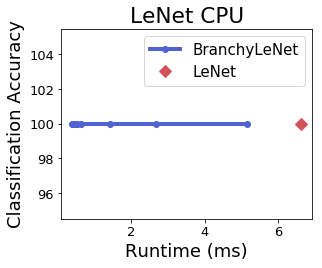

In [21]:
visualize.plot_line_tradeoff(c_accs, c_diffs, c_ts, c_exits, c_baseacc, c_basediff, all_samples=False, inc_amt=-0.0001,
                             our_label='BranchyLeNet', orig_label='LeNet', xlabel='Runtime (ms)',
                             title='LeNet CPU', output_path='_figs/lenet_cpu.pdf')

In [22]:
print 'CPU Results:'
utils.branchy_table_results('LeNet', c_baseacc, c_basediff, c_accs, c_diffs, c_exits, c_ts)

print '\n\n'

print 'GPU Results:'
utils.branchy_table_results('LeNet-MNIST', g_baseacc, g_basediff, g_accs, c_diffs, g_exits, g_ts)

CPU Results:
        Network        Acc.(%)       Time(ms)           Gain      Thrshld.T        Exit(%)
          LeNet         100.00           6.62              -              -              -
        B-LeNet         100.00           5.17           1.28       {0.0001}   {23.0, 77.0}
        B-LeNet         100.00           2.67           2.48       {0.0005}   {69.0, 31.0}
        B-LeNet         100.00           1.42           4.67        {0.001}   {89.0, 11.0}
        B-LeNet         100.00           0.61          10.82        {0.005}    {99.0, 1.0}
        B-LeNet         100.00           0.47          14.17         {0.01}   {100.0, 0.0}
        B-LeNet         100.00           0.52          12.75        {0.025}   {100.0, 0.0}
        B-LeNet         100.00           0.52          12.71         {0.05}   {100.0, 0.0}
        B-LeNet         100.00           0.40          16.42        {0.075}   {100.0, 0.0}
        B-LeNet         100.00           0.40          16.66          {0.1}  

Save model/data

In [23]:
import dill
branchyNet.to_cpu()
with open("_models/lenet_mnist.bn", "wb") as f:
    dill.dump(branchyNet, f)
with open("_models/lenet_mnist_gpu_results.pkl", "wb") as f:
    dill.dump({'accs': g_accs, 'rt': g_diffs, 'exits': g_exits, 'ts': g_ts, 'baseacc': g_baseacc, 'basediff': g_basediff}, f)
with open("_models/lenet_mnist_cpu_results.pkl", "wb") as f:
    dill.dump({'accs': c_accs, 'rt': c_diffs, 'exits': c_exits, 'ts': c_ts, 'baseacc': c_baseacc, 'basediff': c_basediff}, f)

In [24]:
import dill
with open("_models/lenet_mnist_gpu_results.pkl", "rb") as f:
    gpu_res = dill.load(f)
with open("_models/lenet_mnist_cpu_results.pkl", "rb") as f:
    cpu_res = dill.load(f)